# Porfolio Optimization:
Today we will be optimizing a porfolio using Sharpe Ratio

In [ ]:
import pandas as pd 
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
import yfinance as yf

## Download Tickers and close prices

In [2]:
tickers = ['ZB=F','^TYX','TSLA','SPY','QQQ']
end_date = datetime.today()
start_date  = end_date - timedelta(days=(5 * 365))
print(start_date)
print(end_date)

2019-11-23 17:09:18.877066
2024-11-21 17:09:18.877066


In [3]:
adj_close_df = pd.DataFrame()

In [4]:
for ticker in tickers:
    data = yf.download(ticker,start=start_date,end=end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
print(adj_close_df)

                                ZB=F   ^TYX        TSLA         SPY  \
Date                                                                  
2019-11-25 00:00:00+00:00  160.06250  2.207   22.422667  290.084625   
2019-11-26 00:00:00+00:00  160.59375  2.178   21.927999  290.741882   
2019-11-27 00:00:00+00:00  160.09375  2.193   22.086000  292.037811   
2019-11-29 00:00:00+00:00  159.75000  2.202   21.996000  290.954803   
2019-12-02 00:00:00+00:00  158.18750  2.285   22.324667  288.483154   
...                              ...    ...         ...         ...   
2024-11-15 00:00:00+00:00  116.31250  4.601  320.720001  585.750000   
2024-11-18 00:00:00+00:00  116.31250  4.606  338.739990  588.150024   
2024-11-19 00:00:00+00:00  116.90625  4.565  346.000000  590.299988   
2024-11-20 00:00:00+00:00  116.56250  4.592  342.029999  590.500000   
2024-11-21 00:00:00+00:00  116.25000  4.622  339.640015  593.669983   

                                  QQQ  
Date                                

## Calculate LogNormal Returns

In [6]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))

In [ ]:
#Drop Missing Values
log_returns = log_returns.dropna()

Calculate Covariance Matrix

In [8]:
cov_matrix = log_returns.cov()
print(cov_matrix)

          ZB=F      ^TYX      TSLA       SPY       QQQ
ZB=F  0.000057 -0.000170  0.000003 -0.000011 -0.000006
^TYX -0.000170  0.000728  0.000061  0.000086  0.000066
TSLA  0.000003  0.000061  0.001761  0.000284  0.000407
SPY  -0.000011  0.000086  0.000284  0.000176  0.000199
QQQ  -0.000006  0.000066  0.000407  0.000199  0.000261


Calculate standard Deviation, expected return, and Sharpe Ratop of the Porfolio

In [ ]:
# combined volatility of the assets in the porfolio taking into account of their individual volatilities and occrelation with each other.
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)
# Expected Returns based of of historical returns
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252
# define sharpe Ratio
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

Sharpe Ratio Formula

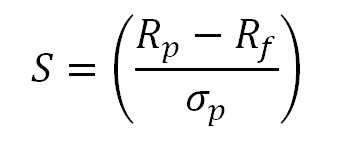

In [ ]:
from fredapi import Fred 
# Todays Risk Free Rate
fred = Fred(api_key = '11cc0017463924b9c382157340ff1539')
ten_year_tresury_rate = fred.get_series_latest_release('GS10') / 100

risk_free_rate = ten_year_tresury_rate.iloc[-1]
print(risk_free_rate)
# from the results import into risk_free_value

0.040999999999999995


In [ ]:

risk_free_rate = 0.040999999999999995
# Define negative Sharpe Ratio (function to minimize)
def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)
#Define Constraints, bounds, and initial weights
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.4) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))
# Optimize weights to maximize Sharpe Ratio using Sequential Least Squares Quadratic Programing method
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [ ]:
#set optimal weights from results 
optimal_weights = optimized_results.x

print("Optimal Weights:")

for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight:.4f}")
#set porfolio functions and print results
optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
ZB=F: 0.0000
^TYX: 0.2097
TSLA: 0.4000
SPY: 0.0000
QQQ: 0.3903
Expected Annual Return: 0.3220
Expected Volatility: 0.0224
Sharpe Ratio: 12.5447


## Conclusion
Our Sharpe Ratio Value is highly exceptional with a expected annual return of 32% which is 20 percent higher than the annual average. Given the optimal weights it is best to remove ZB=F and SPY from the porfolio and look for more optimal stocks for higher returns.

## Plot Results

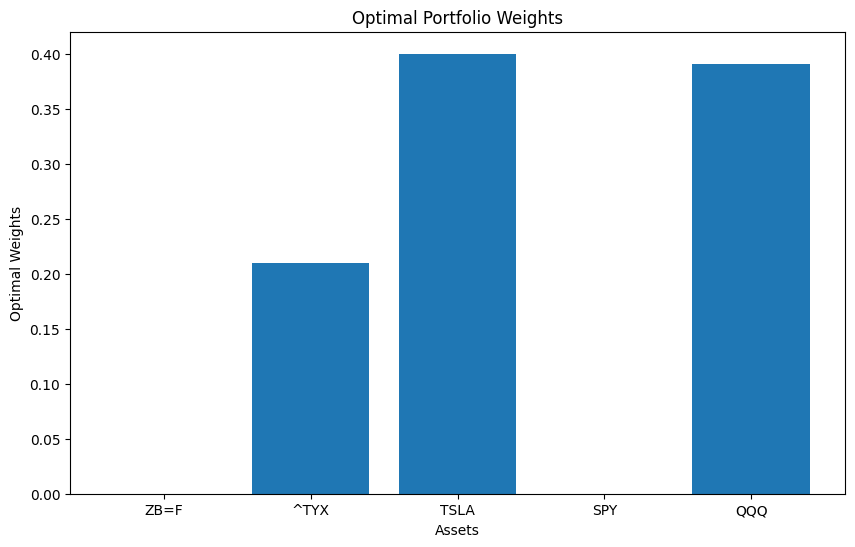

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()